In [464]:
import os
from pathlib import Path
import preprocess

import pandas as pd
import seaborn as sb
import spacy
import wordcloud
from spacy import displacy
from fastlangid.langid import LID

In [197]:
ja_nlp = spacy.load("ja_core_news_lg")
ko_nlp = spacy.load("ko_core_news_lg")
zh_nlp = spacy.load("zh_core_web_lg")

In [199]:
ja_nlp.max_length

1000000

In [225]:
3 * int((2**16 - 1) / 4)

49149

In [227]:
# Max length in bytes of the text that can be passed into the parser
MAX_CHUNK_LEN = 3 * int((2**16 - 1) / 4)

punct = spacy.lang.punctuation.PUNCT.replace("\\", "").split("|")


def collect_policies(path: Path | str) -> dict[str, list[str]]:
    raw_texts: list[str] = []

    for parent, _, files in os.walk(path):
        for filename in files:
            if filename.split(".")[-1] != "txt":
                continue
            with open(f"{parent}/{filename}", "r") as file:
                file_text = file.read()
                while len(file_text.encode("utf-8")) > MAX_CHUNK_LEN:
                    # Divide by 4 as one utf-8 character can be up to 4 bytes long.
                    cursor = MAX_CHUNK_LEN // 4
                    while file_text[cursor] not in punct:
                        cursor -= 1

                    raw_texts.append(file_text[0:cursor])
                    file_text = file_text[cursor:]
                raw_texts.append(file_text)

    classified: dict[str, list[str]] = {}
    classifier = LID()
    for text in raw_texts:
        lang = classifier.predict(text)
        try:
            classified[lang].append(text)
        except KeyError:
            classified[lang] = []
    return classified

In [472]:
preprocess.process(["你好！我喜欢中文。"], "cn")[0]

,token,head,ent_type,ent_status,pos,is_digit,is_punct,is_sent_start,is_sent_end,is_bracket,is_quote,like_url,like_num,like_email,is_stop
0,你好,你好,,O,VERB,False,False,True,False,False,False,False,False,False,False
1,！,你好,,O,PUNCT,False,True,False,True,False,False,False,False,False,True
2,我,喜欢,,O,PRON,False,False,True,False,False,False,False,False,False,True
3,喜欢,喜欢,,O,VERB,False,False,False,False,False,False,False,False,False,False
4,中文,喜欢,LANGUAGE,B,NOUN,False,False,False,False,False,False,False,False,False,False
5,。,喜欢,,O,PUNCT,False,True,False,True,False,False,False,False,False,True


In [228]:
pols = collect_policies(Path("../crawler/policies"))

In [460]:
{k: len(v) for (k, v) in pols.items()}

{'zh-hant': 7, 'zh-hans': 26, 'en': 1, 'ja': 29, 'ko': 30}

In [231]:
ko_docs = list(ko_nlp.pipe(pols["ko"], n_process=-1))
ja_docs = list(ja_nlp.pipe(pols["ja"], n_process=-1))
zh_docs = list(zh_nlp.pipe(pols["zh-hant"] + pols["zh-hans"], n_process=-1))

In [232]:
def toks_per_sent(docs):
    return [len(sent) for doc in docs for sent in doc.sents]

In [450]:
df = pd.DataFrame(
    [
        (
            t.text,
            t.head,
            t.ent_type_,
            t.ent_iob_,
            t.pos_,
            t.is_digit,
            t.is_punct,
            t.is_sent_start,
            t.is_sent_end,
            t.is_bracket,
            t.is_quote,
            t.like_url,
            t.like_num,
            t.like_email,
            t.is_stop,
        )
        for t in x
    ],
    columns=[
        "token",
        "head",
        "ent_type",
        "ent_status",
        "pos",
        "is_digit",
        "is_punct",
        "is_sent_start",
        "is_sent_end",
        "is_bracket",
        "is_quote",
        "like_url",
        "like_num",
        "like_email",
        "is_stop",
    ],
)

In [451]:
df

,token,head,ent_type,ent_status,pos,is_digit,is_punct,is_sent_start,is_sent_end,is_bracket,is_quote,like_url,like_num,like_email,is_stop
0,Privacy,|,PRODUCT,B,NOUN,False,False,True,False,False,False,False,False,False,False
1,Policy,|,PRODUCT,I,NOUN,False,False,False,False,False,False,False,False,False,False
2,|,編集,PRODUCT,I,NOUN,False,False,False,False,False,False,False,False,False,False
3,動画,編集,PRODUCT,I,NOUN,False,False,False,False,False,False,False,False,False,False
4,編集,編集,,O,NOUN,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918,の,仕事,,O,ADP,False,False,False,False,False,False,False,False,False,True
1919,お,Policy,,O,NOUN,False,False,False,False,False,False,False,False,False,True
1920,問い合わせ,Policy,,O,NOUN,False,False,False,False,False,False,False,False,False,False
1921,Privacy,Policy,ORG,B,NOUN,False,False,False,False,False,False,False,False,False,False


In [312]:
displacy.render(ja_docs[16][:1000], style="ent")

<Axes: >

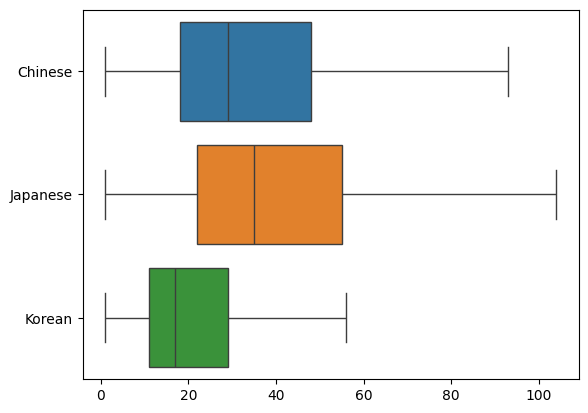

In [104]:
sb.boxplot(
    {
        "Chinese": toks_per_sent(zh_docs),
        "Japanese": toks_per_sent(ja_docs),
        "Korean": toks_per_sent(ko_docs),
    },
    orient="y",
    showfliers=False,
)

In [105]:
def get_freqs(text: list[str]) -> dict[str, int]:
    freq = {}
    for entry in text:
        if freq.get(entry) is None:
            freq[entry] = 1
        else:
            freq[entry] += 1
    return freq

In [106]:
# Replace this with the path to the font to use on your system
font_path = "/usr/share/fonts/noto-cjk/NotoSansCJK-Regular.ttc"

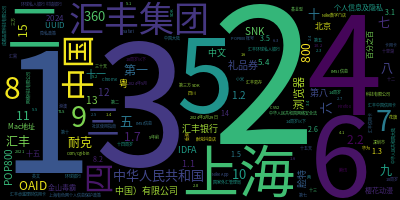

In [107]:
# Chinese
cloud = wordcloud.WordCloud(font_path=font_path)
freqs = get_freqs([str(ent) for doc in zh_docs for ent in doc.ents])
cloud.generate_from_frequencies(freqs)
cloud.to_image()

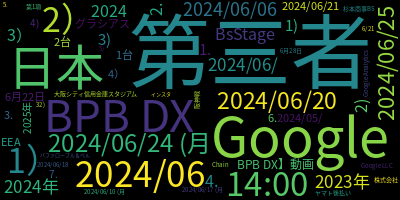

In [108]:
# Japanese
cloud = wordcloud.WordCloud(font_path=font_path)
freqs = get_freqs([str(ent) for doc in ja_docs for ent in doc.ents])
cloud.generate_from_frequencies(freqs)
cloud.to_image()

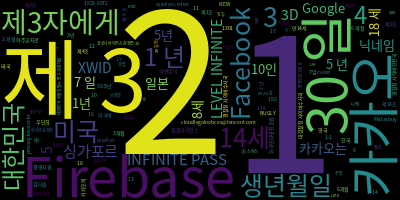

In [109]:
# Korean
cloud = wordcloud.WordCloud(font_path=font_path)
freqs = get_freqs([str(ent) for doc in ko_docs for ent in doc.ents])
cloud.generate_from_frequencies(freqs)
cloud.to_image()